# Create MP2RAGE Image

In [24]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from  adam_utils.nifti import plot_nifti
import nibabel as nib
import t1_mapping
from scipy.interpolate import RegularGridInterpolator

## Load data

In [25]:
# Load dataset paths
subject = '334264'
scan = '401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE'
scan_num = '401'
scan_times = ['1010', '3310', '5610']
dataset_path = '/nfs/masi/saundam1/outputs/t1_mapping/mp2rage_converted_v2023/'
subject_path = os.path.join(dataset_path, subject, scan)

# Load NIFTI files
inv1_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[0]}.nii'))
inv1_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[0]}.nii'))
inv2_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[1]}.nii'))
inv2_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[1]}.nii'))
inv3_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[2]}.nii'))
inv3_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[2]}.nii'))

# Load data from NIFTI
inv1_real_data = inv1_real.get_fdata()
inv1_imag_data = inv1_imag.get_fdata()
inv2_real_data = inv2_real.get_fdata()
inv2_imag_data = inv2_imag.get_fdata()
inv3_real_data = inv3_real.get_fdata()
inv3_imag_data = inv3_imag.get_fdata()

## Calculate MP2RAGE image

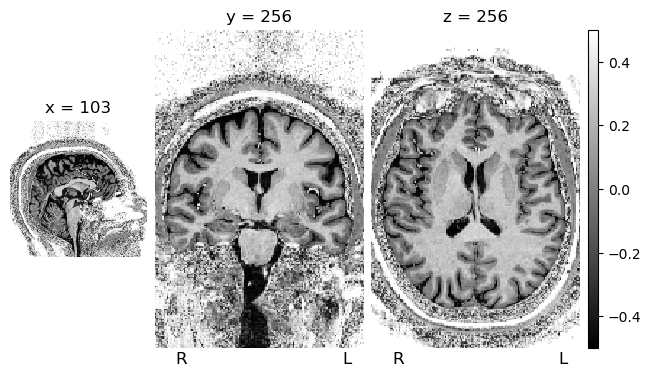

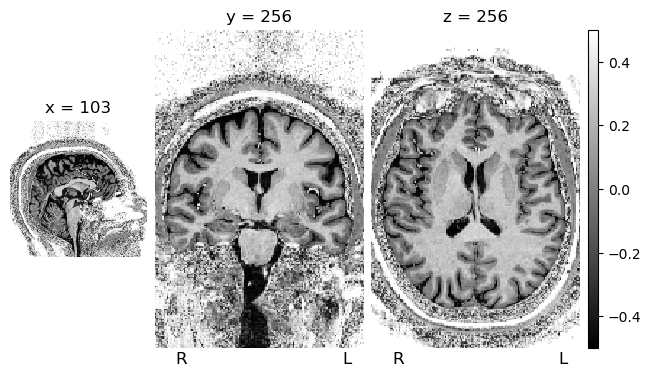

In [26]:
# Create combined complex data
inv1_data = inv1_real_data + 1j*inv1_imag_data
inv2_data = inv2_real_data + 1j*inv2_imag_data
inv3_data = inv3_real_data + 1j*inv3_imag_data

# Calculate MP2RAGE image
mp2rage1 = mp2rage_t1w(inv1_data, inv2_data)
mp2rage1_nifti = nib.nifti2.Nifti2Image(mp2rage, inv1_real.affine)

mp2rage2 = mp2rage_t1w(inv1_data, inv3_data)
mp2rage2_nifti = nib.nifti2.Nifti2Image(mp2rage, inv1_real.affine)

# Plot
fig, ax = plot_nifti(mp2rage1_nifti)
fig, ax = plot_nifti(mp2rage2_nifti)

# Create T1 map

[[0.82043844 0.91401989 0.92606384 ... 0.         0.         0.        ]
 [0.88828215 0.94947199 0.95707318 ... 0.         0.         0.        ]
 [0.86958554 0.94052504 0.94978318 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99849059 0.99866857 0.99668515]
 [0.         0.         0.         ... 0.99867639 0.99940222 0.99944714]
 [0.         0.         0.         ... 0.9966986  0.99944713 0.9997582 ]]


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'x = 103'}>,
        <Axes: title={'center': 'y = 256'}>,
        <Axes: title={'center': 'z = 256'}>], dtype=object))

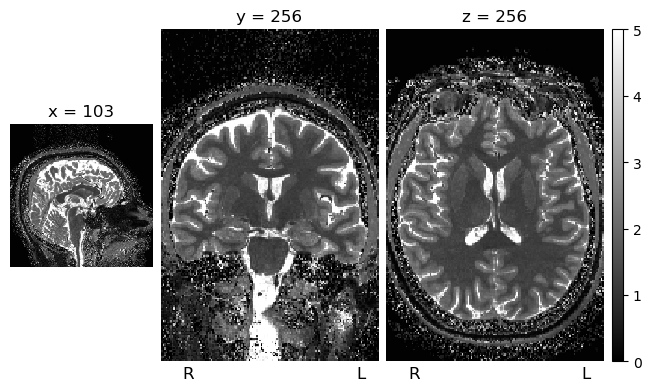

In [39]:
# Define arrays
n_pairs = 2
m_ranges = [(-0.5, 0.5), (-0.5, 0.5)]
m = [np.linspace(m[0], m[1], 100) for m in m_ranges]
delta_t1 = 0.05
t1 = np.arange(delta_t1, 5 + delta_t1, delta_t1)
num_points = t1.shape[0]
delta_m = [(m[1]-m[0])/(num_points-1) for m in m_ranges]

# Calculate posterior
monte_carlo = '/nfs/masi/saundam1/outputs/t1_mapping/distr/counts_100M_spacing.npy'
counts = np.load(monte_carlo)

posterior = counts / np.sum(counts * delta_t1)

# MAP estimate
map_est = np.max(posterior, axis=-1)
map_args = np.argmax(posterior, axis=-1)

# Uniform likelihood
likelihood = counts / np.sum(counts*np.prod(delta_m), axis=tuple(range(n_pairs)))
max_L_gauss = np.max(likelihood, axis=-1)
total_vol = np.prod(m[1]-m[0] for m in m_ranges)
m_squares = np.array([len(mp2rage) for mp2rage in m])
total_squares = np.prod(m_squares)
uni_value = 1/(total_squares*np.prod(delta_m))
L_uni = np.full(tuple(m_squares), uni_value)
alpha = max_L_gauss / (max_L_gauss + L_uni)

# Create LUT
t1_lut = t1[map_args]
t1_lut[alpha < 0.5] = 0

# Create grid
interp = RegularGridInterpolator(tuple(m), values=t1_lut,
    bounds_error=False, fill_value=0, method='linear')

# Clip to [-0.5, 0.5] to accounting for floating-point errors
t1w = [mp2rage1, mp2rage2]
t1w = [np.clip(t, -0.5, 0.5) for t in t1w]

# Interpolate along new values
pts = tuple([t.flatten() for t in t1w])
t1_calc = interp(pts).reshape(t1w[0].shape)

t1_calc_nifti = nib.nifti1.Nifti1Image(t1_calc, inv1_real.affine)
plot_nifti(t1_calc_nifti)


# Save to file

In [40]:
t1_calc_nifti.to_filename(os.path.join(t1_mapping.definitions.OUTPUTS, 'test', 't1_calc.nii.gz'))